<a href="https://colab.research.google.com/github/SFStefenon/MCOMFS/blob/main/Proposed_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wrote by Dr. **Stefano Frizzo Stefenon**

Postdoctoral fellow at University of Regina

Faculty of Engineering and Applied Sciences

Regina, SK, Canada, 2025.

___

After loading the libraries and the dataset, the proposed analysis is divided according to:

*   **Standard model**: Run the TFT model considering its default setup and original dataset.
*   **Filter**: Compute the evaluated filter individuality (CF, HP, STL, and MSTL).
*   **Denoised model**: Run the TFT model considering the denoised time series.
*   **Optuna**: Compute the multi-criteria optimization for model and filter selection.
*   **Optimized**: Run the optimized model considering the denoised time series.
*   **Stats**: Run several experiments and save them for statistical evaluation.
*   **Benchmarking**: Compute several different models considering their default setups.

# Libraries

In [1]:
pip install -q neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.models import DilatedRNN
from neuralforecast.models import NHITS
from neuralforecast.models import DeepNPTS
from neuralforecast.models import TCN
from neuralforecast.models import LSTM
from neuralforecast.models import RNN
from neuralforecast.models import MLP
from neuralforecast.models import NBEATS

In [3]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import MSTL
import statsmodels.api as sm

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

def smape(a, f): # Compute SMAPE
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
def make_Tensor(array): # Tensor transformation
    return torch.from_numpy(array).float()

# Dataset

## Data - Original

In [ ]:
# Load the dataset
data_o = pd.read_csv("DADOS_HIDROLOGICOS_RES.csv", delimiter=';', decimal='.')
inflow_o = list(data_o['val_vazaoafluente'])
time = list(data_o['din_instante'])
years = 3
inflow = inflow_o[(-365*years):-1]

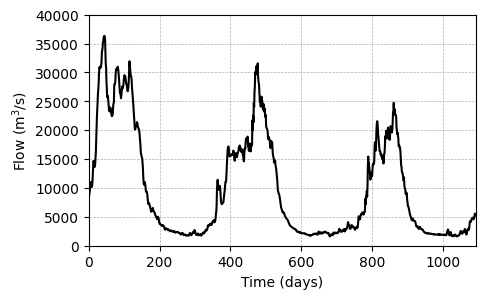

In [ ]:
fig, ((ax2)) = plt.subplots(1, 1, figsize=(5, 3), dpi=100)
ax2.plot(inflow,'k', zorder=2)
ax2.set_ylabel('Flow (m$^3$/s)')
ax2.set_xlabel('Time (days)')
ax2.axis([0, len(inflow), 0, 40000])
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
plt.show
plt.savefig('Original.pdf', bbox_inches = 'tight')

# Standard Model

In [ ]:
# Load the dataset
data_o = pd.read_csv("DADOS_HIDROLOGICOS_RES.csv", delimiter=';', decimal='.')
inflow_o = list(data_o['val_vazaoafluente'])
time = list(data_o['din_instante'])
inflow = inflow_o[(-365*3):-1]

# Create the time data
horizon = 14
x = inflow
time_data = pd.date_range(time[0], periods=len(x), freq='D')

# Create the DataFrame
df = pd.DataFrame({
    'unique_id': np.array(['Airline1'] * len(x)),
    'ds': time_data,
    'y': x,
    'trend': np.arange(len(x)),})

# Display the DataFrame
print(df.head())
print(df.tail())

# Split data based on your criteria
# Calculate split point for 70-10 split
split_point = int(len(df) * 0.70)

# Split data into 90% training and 10% testing
Y_train_df = df.iloc[:split_point].reset_index(drop=True)
Y_test_df = df.iloc[split_point:].reset_index(drop=True)

# Adjust input_size to fit within the training data length
input_size = min(2 * horizon, len(Y_train_df))

import time
start = time.time()
models = [TFT(input_size=horizon, h=horizon, max_steps=100)]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()
end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.TFT[:horizon]
y_true = Y_test_df.y[:horizon]
rmse(y_true, y_pred)

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


  unique_id         ds     y  trend
0  Airline1 2021-01-01  8708      0
1  Airline1 2021-01-02  8636      1
2  Airline1 2021-01-03  9058      2
3  Airline1 2021-01-04  9479      3
4  Airline1 2021-01-05  9941      4
     unique_id         ds     y  trend
1089  Airline1 2023-12-26  5082   1089
1090  Airline1 2023-12-27  5568   1090
1091  Airline1 2023-12-28  5450   1091
1092  Airline1 2023-12-29  5254   1092
1093  Airline1 2023-12-30  5268   1093


INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 129    | train
-----------------------------------------------------------------------------
870 K     Trainable params
0         Non-trainable params
870 K     Total params
3.481     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2.33E+02 & 1.82E+02 & 3.52E-02 & 3.46E+00 & 317.38


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


# Filter

In [ ]:
x = inflow
f = pd.Series(x, index=pd.date_range(x[0], periods=len(x), freq="D"), name="DF")

In [ ]:
# Denoising
x_resd_cf, x_trend_cf = sm.tsa.filters.cffilter(f, 2, 35, False)
x_cf = list(x_trend_cf)
x_resd_hp, x_trend_hp = sm.tsa.filters.hpfilter(f, 35)
x_hp = list(x_trend_hp)
x_trend_mstl = MSTL(f, periods=(24, 35)).fit()
x_mstl = list(x_trend_mstl.trend)
stl = STL(f, trend=35, seasonal=7)
x_stl = list((stl.fit()).trend)

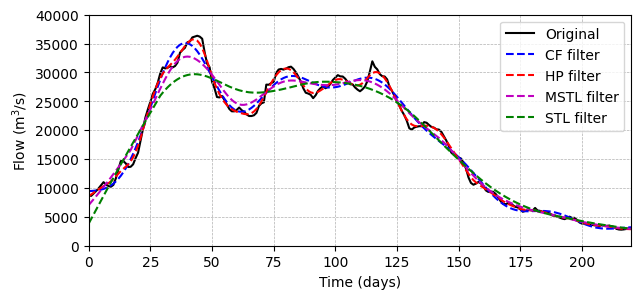

In [ ]:
fig, ((ax1)) = plt.subplots(1, figsize=(7, 3), dpi=100)

ax1.plot(x,'k', zorder=0)
ax1.plot(x_cf,'b', zorder=2, linestyle='dashed')
ax1.plot(x_hp,'r', zorder=2, linestyle='dashed')
ax1.plot(x_stl,'m', zorder=2, linestyle='dashed')
ax1.plot(x_mstl,'g', zorder=2, linestyle='dashed')
ax1.set_ylabel('Flow (m$^3$/s)')
ax1.set_xlabel('Time (days)')
ax1.set_xlim(0, 220)
ax1.set_ylim(0, 40000)
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(["Original", "CF filter", "HP filter", "MSTL filter", "STL filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)
plt.show
plt.savefig('Trend.pdf', bbox_inches = 'tight')

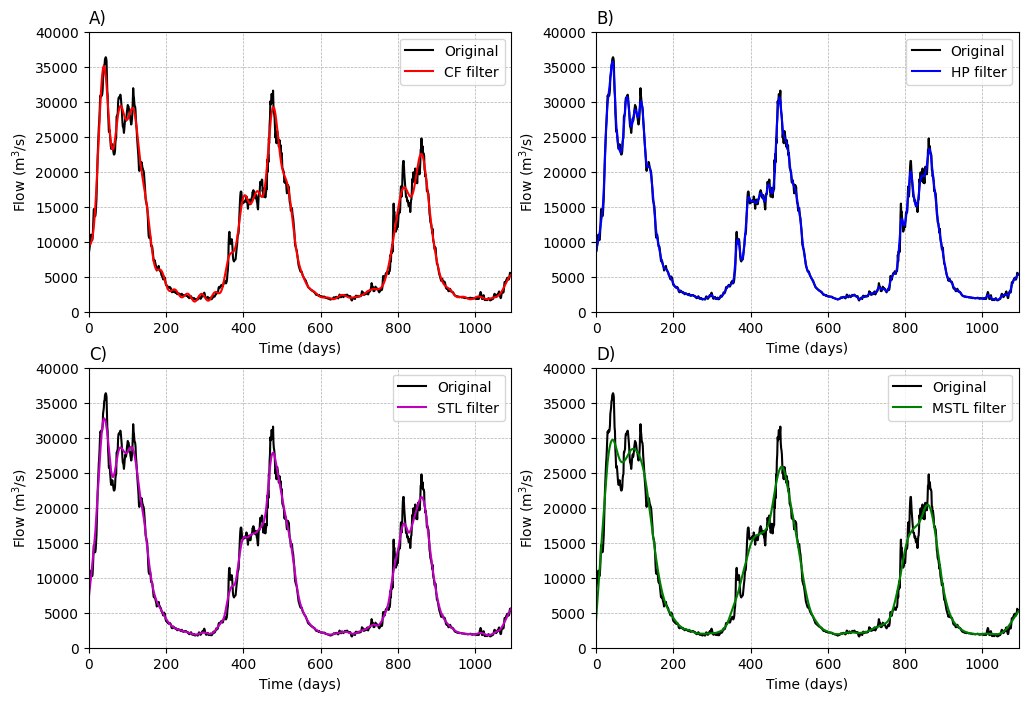

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), dpi=100)

ax1.plot(x,'k', zorder=2)
ax1.plot(x_cf,'r', zorder=2)
ax1.set_title('A)', loc='left')
ax1.set_ylabel('Flow (m$^3$/s)')
ax1.set_xlabel('Time (days)')
ax1.set_xlim(0, len(x))
ax1.set_ylim(0, 40000)
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(["Original", "CF filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)

ax2.plot(x,'k', zorder=2)
ax2.plot(x_hp,'b', zorder=2)
ax2.set_title('B)', loc='left')
ax2.set_ylabel('Flow (m$^3$/s)')
ax2.set_xlabel('Time (days)')
ax2.set_xlim(0, len(x))
ax2.set_ylim(0, 40000)
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax2.legend(["Original", "HP filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)

ax3.plot(x,'k', zorder=2)
ax3.plot(x_stl,'m', zorder=2)
ax3.set_title('C)', loc='left')
ax3.set_ylabel('Flow (m$^3$/s)')
ax3.set_xlabel('Time (days)')
ax3.set_xlim(0, len(x))
ax3.set_ylim(0, 40000)
ax3.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax3.legend(["Original", "STL filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)

ax4.plot(x,'k', zorder=2)
ax4.plot(x_mstl,'g', zorder=2)
ax4.set_title('D)', loc='left')
ax4.set_ylabel('Flow (m$^3$/s)')
ax4.set_xlabel('Time (days)')
ax4.set_xlim(0, len(x))
ax4.set_ylim(0, 40000)
ax4.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax4.legend(["Original", "MSTL filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)
plt.show
plt.savefig('Trend.pdf', bbox_inches = 'tight')

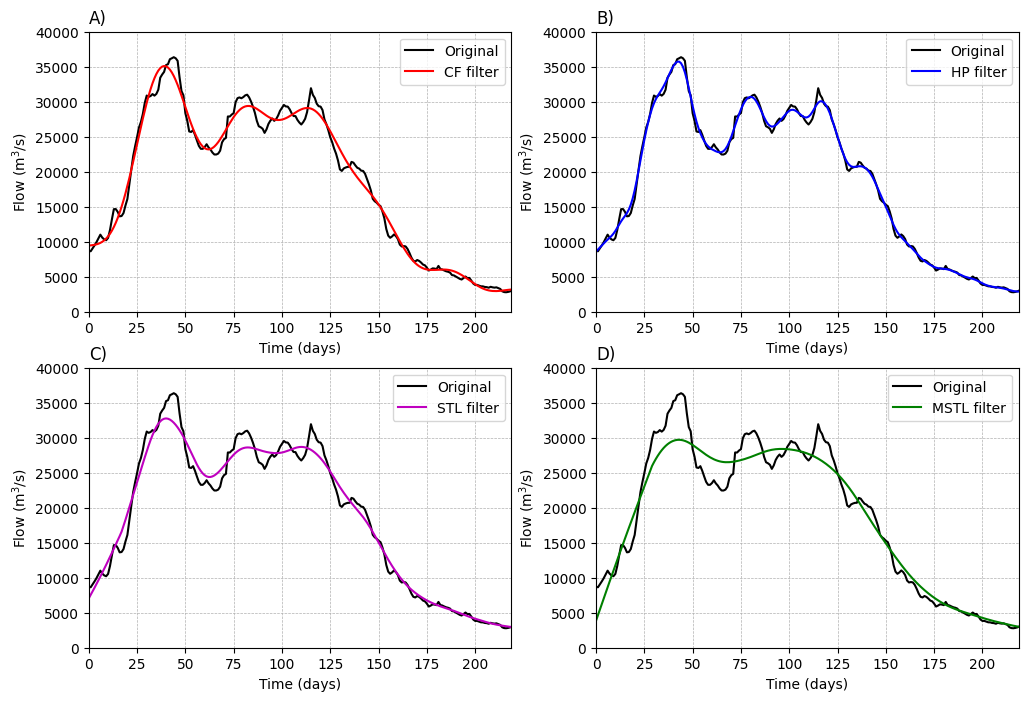

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), dpi=100)

ax1.plot(x,'k', zorder=2)
ax1.plot(x_cf,'r', zorder=2)
ax1.set_title('A)', loc='left')
ax1.set_ylabel('Flow (m$^3$/s)')
ax1.set_xlabel('Time (days)')
ax1.set_xlim(0, len(x)*.2)
ax1.set_ylim(0, 40000)
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(["Original", "CF filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)

ax2.plot(x,'k', zorder=2)
ax2.plot(x_hp,'b', zorder=2)
ax2.set_title('B)', loc='left')
ax2.set_ylabel('Flow (m$^3$/s)')
ax2.set_xlabel('Time (days)')
ax2.set_xlim(0, len(x)*.2)
ax2.set_ylim(0, 40000)
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax2.legend(["Original", "HP filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)

ax3.plot(x,'k', zorder=2)
ax3.plot(x_stl,'m', zorder=2)
ax3.set_title('C)', loc='left')
ax3.set_ylabel('Flow (m$^3$/s)')
ax3.set_xlabel('Time (days)')
ax3.set_xlim(0, len(x)*.2)
ax3.set_ylim(0, 40000)
ax3.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax3.legend(["Original", "STL filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)

ax4.plot(x,'k', zorder=2)
ax4.plot(x_mstl,'g', zorder=2)
ax4.set_title('D)', loc='left')
ax4.set_ylabel('Flow (m$^3$/s)')
ax4.set_xlabel('Time (days)')
ax4.set_xlim(0, len(x)*.2)
ax4.set_ylim(0, 40000)
ax4.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax4.legend(["Original", "MSTL filter"], loc="upper right", fancybox=True, shadow=False, ncol=1)
plt.show
plt.savefig('Trend.pdf', bbox_inches = 'tight')

# Denoised model

In [ ]:
# Load the dataset
data_o = pd.read_csv("DADOS_HIDROLOGICOS_RES.csv", delimiter=';', decimal='.')
inflow_o = list(data_o['val_vazaoafluente'])
time = list(data_o['din_instante'])
x = inflow_o[(-365*3):-1]
f = pd.Series(x, index=pd.date_range(x[0], periods=len(x), freq="D"), name="DF")

# Denoising
x_resd_cf, x_trend_cf = sm.tsa.filters.cffilter(f, 2, 35, False)
x_cf = list(x_trend_cf)
x_resd_hp, x_trend_hp = sm.tsa.filters.hpfilter(f, 35)
x_hp = list(x_trend_hp)
x_trend_mtsl = MSTL(f, periods=(24, 35)).fit()
x_mstl = list(x_trend_mtsl.trend)
stl = STL(f, trend=35, seasonal=7)
x_stl = list((stl.fit()).trend)

# x = x_cf
# x = x_hp
x = x_mstl
# x = x_stl

# Create the time data
horizon = 14
time_data = pd.date_range(time[0], periods=len(x), freq='D')

# Create the DataFrame
df = pd.DataFrame({
    'unique_id': np.array(['Airline1'] * len(x)),
    'ds': time_data,
    'y': x,
    'trend': np.arange(len(x)),})

# Split data based on your criteria
split_point = int(len(df) * 0.7)
Y_train_df = df.iloc[:split_point].reset_index(drop=True)
Y_test_df = df.iloc[split_point:].reset_index(drop=True)

# Adjust input_size to fit within the training data length
input_size = min(2 * horizon, len(Y_train_df))

import time
start = time.time()
models = [TFT(input_size=horizon, h=horizon, max_steps=100)]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()
end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.TFT[:horizon]
y_true = Y_test_df.y[:horizon]
rmse(y_true, y_pred)

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2.65E+02 & 2.07E+02 & 3.13E-02 & 3.20E+00 & 303.12


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2.65E+02 & 2.07E+02 & 3.13E-02 & 3.20E+00 & 321.86


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


# Optuna


In [ ]:
!pip install -q optuna
import optuna

In [ ]:
# Load the dataset
horizon = 14
data_o = pd.read_csv("DADOS_HIDROLOGICOS_RES.csv", delimiter=';', decimal='.')
inflow_o = list(data_o['val_vazaoafluente'])
time = list(data_o['din_instante'])

## Exp 1


In [ ]:
def attention(a,b):
  x = inflow_o[(-365*3):-1]
  f = pd.Series(x, index=pd.date_range(x[0], periods=len(x), freq="D"), name="DF")
  if b == "Original":
    pass
  elif b == "CF":
    x_resd_cf, x_trend_cf = sm.tsa.filters.cffilter(f, 2, a, False)
    x = list(x_trend_cf)
  elif b == "HP":
    x_resd_hp, x_trend_hp = sm.tsa.filters.hpfilter(f, a)
    x = list(x_trend_hp)
  elif b == "STL":
    if a % 2 == 0:
      a = a+1 # To keep only odds for the STL
    stl = STL(f, seasonal=7, trend=a)
    x_stl = list((stl.fit()).trend)
  elif b == "MSTL":
    x_trend_mstl = MSTL(f, periods=(24, a)).fit()
    x_mstl = list(x_trend_mstl.trend)

  time_data = pd.date_range(time[0], periods=len(x), freq='D')
  df = pd.DataFrame({'unique_id': np.array(['Airline1'] * len(x)),
      'ds': time_data, 'y': x, 'trend': np.arange(len(x)),})
  split_point = int(len(df) * 0.70)
  Y_train_df = df.iloc[:split_point].reset_index(drop=True)
  Y_test_df = df.iloc[split_point:].reset_index(drop=True)
  input_size = min(2 * horizon, len(Y_train_df))

  models = [TFT(input_size=horizon, h=horizon, max_steps=30)]
  nf = NeuralForecast(models=models, freq='d')
  nf.fit(df=Y_train_df)
  Y_hat_df = nf.predict().reset_index()
  y_pred = Y_hat_df.TFT[:horizon]
  y_true = Y_test_df.y[:horizon]
  rmse(y_true, y_pred)
  return rmse(y_true, y_pred)

def objective(trial):
    a = trial.suggest_int('Hyperparameter', 1, 100)
    b = trial.suggest_categorical("Input_data", ["Original", "CF", "HP", "STL", "MSTL"])
    erro = attention(a,b)
    return erro

study = optuna.create_study()
study.optimize(objective, n_trials=50)

study.best_params

[I 2024-12-08 21:23:51,874] A new study created in memory with name: no-name-a3c2f61c-bd6b-4950-8a05-82fa3623fa01
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:25:36,501] Trial 0 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 51, 'Input_data': 'MSTL'}. Best is trial 0 with value: 961.0018111806575.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Na

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:27:07,278] Trial 1 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 79, 'Input_data': 'MSTL'}. Best is trial 0 with value: 961.0018111806575.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Na

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:28:37,327] Trial 2 finished with value: 825.0209786555198 and parameters: {'Hyperparameter': 94, 'Input_data': 'CF'}. Best is trial 2 with value: 825.0209786555198.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:30:08,556] Trial 3 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 64, 'Input_data': 'Original'}. Best is trial 2 with value: 825.0209786555198.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:31:38,199] Trial 4 finished with value: 296.3066000024359 and parameters: {'Hyperparameter': 13, 'Input_data': 'HP'}. Best is trial 4 with value: 296.3066000024359.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:33:16,886] Trial 5 finished with value: 755.0347695955503 and parameters: {'Hyperparameter': 95, 'Input_data': 'CF'}. Best is trial 4 with value: 296.3066000024359.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:35:01,312] Trial 6 finished with value: 326.84868305900187 and parameters: {'Hyperparameter': 75, 'Input_data': 'HP'}. Best is trial 4 with value: 296.3066000024359.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Nam

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:36:32,678] Trial 7 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 97, 'Input_data': 'Original'}. Best is trial 4 with value: 296.3066000024359.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:38:06,372] Trial 8 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 52, 'Input_data': 'Original'}. Best is trial 4 with value: 296.3066000024359.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:39:36,158] Trial 9 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 67, 'Input_data': 'MSTL'}. Best is trial 4 with value: 296.3066000024359.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Na

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:41:05,494] Trial 10 finished with value: 427.6049549766103 and parameters: {'Hyperparameter': 6, 'Input_data': 'HP'}. Best is trial 4 with value: 296.3066000024359.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:42:35,043] Trial 11 finished with value: 264.6066553614566 and parameters: {'Hyperparameter': 16, 'Input_data': 'HP'}. Best is trial 11 with value: 264.6066553614566.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Na

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:44:04,584] Trial 12 finished with value: 256.35014710802716 and parameters: {'Hyperparameter': 17, 'Input_data': 'HP'}. Best is trial 12 with value: 256.35014710802716.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:45:34,909] Trial 13 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 21, 'Input_data': 'STL'}. Best is trial 12 with value: 256.35014710802716.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:47:04,501] Trial 14 finished with value: 259.2606131037652 and parameters: {'Hyperparameter': 28, 'Input_data': 'HP'}. Best is trial 12 with value: 256.35014710802716.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:48:35,509] Trial 15 finished with value: 238.55706395434365 and parameters: {'Hyperparameter': 32, 'Input_data': 'HP'}. Best is trial 15 with value: 238.55706395434365.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:50:05,971] Trial 16 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 35, 'Input_data': 'STL'}. Best is trial 15 with value: 238.55706395434365.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:51:38,058] Trial 17 finished with value: 214.19238618603592 and parameters: {'Hyperparameter': 36, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:53:10,914] Trial 18 finished with value: 247.43548539811098 and parameters: {'Hyperparameter': 39, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:54:41,262] Trial 19 finished with value: 287.53636784096307 and parameters: {'Hyperparameter': 43, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:56:11,993] Trial 20 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 2, 'Input_data': 'CF'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Na

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:57:41,890] Trial 21 finished with value: 230.62950592285026 and parameters: {'Hyperparameter': 37, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 21:59:12,598] Trial 22 finished with value: 223.0141327509651 and parameters: {'Hyperparameter': 29, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:00:43,884] Trial 23 finished with value: 241.04145454627567 and parameters: {'Hyperparameter': 47, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:02:13,854] Trial 24 finished with value: 239.20399505091194 and parameters: {'Hyperparameter': 26, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:03:44,502] Trial 25 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 59, 'Input_data': 'STL'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:05:14,589] Trial 26 finished with value: 255.99545480423478 and parameters: {'Hyperparameter': 40, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:06:44,722] Trial 27 finished with value: 244.1479197187452 and parameters: {'Hyperparameter': 27, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:08:14,172] Trial 28 finished with value: 265.84000207312494 and parameters: {'Hyperparameter': 34, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:09:43,862] Trial 29 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 58, 'Input_data': 'STL'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:11:13,363] Trial 30 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 50, 'Input_data': 'MSTL'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:12:42,838] Trial 31 finished with value: 214.19238618603592 and parameters: {'Hyperparameter': 36, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:14:12,005] Trial 32 finished with value: 255.27176399810168 and parameters: {'Hyperparameter': 44, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:15:41,916] Trial 33 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 21, 'Input_data': 'MSTL'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:17:11,742] Trial 34 finished with value: 2321.6109202235803 and parameters: {'Hyperparameter': 33, 'Input_data': 'CF'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:18:42,113] Trial 35 finished with value: 353.9670361073757 and parameters: {'Hyperparameter': 10, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:20:11,908] Trial 36 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 54, 'Input_data': 'Original'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:21:41,094] Trial 37 finished with value: 249.71787097014 and parameters: {'Hyperparameter': 38, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Nam

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:23:10,500] Trial 38 finished with value: 668.1866175431678 and parameters: {'Hyperparameter': 23, 'Input_data': 'CF'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:24:40,323] Trial 39 finished with value: 223.0141327509651 and parameters: {'Hyperparameter': 29, 'Input_data': 'HP'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:26:09,709] Trial 40 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 86, 'Input_data': 'Original'}. Best is trial 17 with value: 214.19238618603592.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:27:38,934] Trial 41 finished with value: 192.65228726540485 and parameters: {'Hyperparameter': 30, 'Input_data': 'HP'}. Best is trial 41 with value: 192.65228726540485.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:29:12,014] Trial 42 finished with value: 192.65228726540485 and parameters: {'Hyperparameter': 30, 'Input_data': 'HP'}. Best is trial 41 with value: 192.65228726540485.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:30:41,653] Trial 43 finished with value: 253.3271610186971 and parameters: {'Hyperparameter': 45, 'Input_data': 'HP'}. Best is trial 41 with value: 192.65228726540485.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:32:10,585] Trial 44 finished with value: 312.1023515341026 and parameters: {'Hyperparameter': 12, 'Input_data': 'HP'}. Best is trial 41 with value: 192.65228726540485.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:33:39,963] Trial 45 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 17, 'Input_data': 'MSTL'}. Best is trial 41 with value: 192.65228726540485.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:35:08,900] Trial 46 finished with value: 233.3487872991152 and parameters: {'Hyperparameter': 31, 'Input_data': 'HP'}. Best is trial 41 with value: 192.65228726540485.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:36:38,315] Trial 47 finished with value: 191.39552038344902 and parameters: {'Hyperparameter': 24, 'Input_data': 'HP'}. Best is trial 47 with value: 191.39552038344902.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:38:07,636] Trial 48 finished with value: 961.0018111806575 and parameters: {'Hyperparameter': 21, 'Input_data': 'Original'}. Best is trial 47 with value: 191.39552038344902.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-12-08 22:39:36,631] Trial 49 finished with value: 233.87303732708915 and parameters: {'Hyperparameter': 25, 'Input_data': 'HP'}. Best is trial 47 with value: 191.39552038344902.


{'Hyperparameter': 24, 'Input_data': 'HP'}

In [ ]:
print("Best params: ", study.best_params)

Best params:  {'Hyperparameter': 24, 'Input_data': 'HP'}


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_contour(study, params=["Hyperparameter", "Input_data"])

<ipython-input-27-8dcd307c1780>:1: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Parallel Coordinate Plot'}>

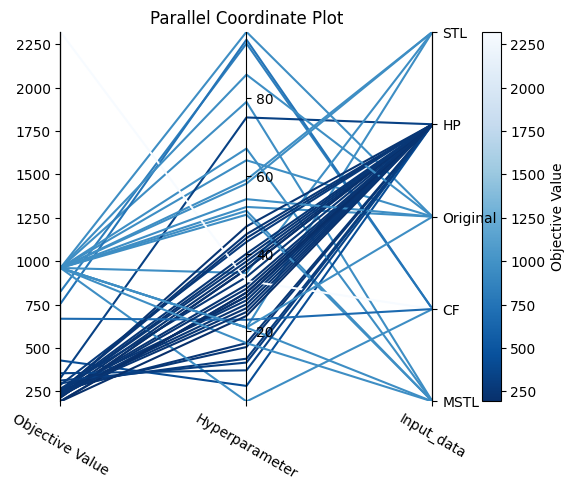

In [ ]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["Hyperparameter", "Input_data"])

## Exp 2

In [ ]:
max_steps = 30
n_trials = 50

In [ ]:
def attention(a,b,c):
  x = inflow_o[(-365*3):-1]
  f = pd.Series(x, index=pd.date_range(x[0], periods=len(x), freq="D"), name="DF")
  x_resd_hp, x_trend_hp = sm.tsa.filters.hpfilter(f, 24)
  x = list(x_trend_hp)
  time_data = pd.date_range(time[0], periods=len(x), freq='D')
  df = pd.DataFrame({'unique_id': np.array(['Airline1'] * len(x)),
      'ds': time_data, 'y': x, 'trend': np.arange(len(x)),})
  split_point = int(len(df) * 0.70)
  Y_train_df = df.iloc[:split_point].reset_index(drop=True)
  Y_test_df = df.iloc[split_point:].reset_index(drop=True)
  input_size = min(2 * horizon, len(Y_train_df))
  RMSE = 1000

  if b == "StandardRNN":
    models = [RNN (input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.RNN[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "DilatedRNN":
    models = [DilatedRNN (input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.DilatedRNN [:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "LSTM":
    models = [LSTM (input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.LSTM[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "TFT":
    models = [TFT(input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.TFT[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "NHITS":
    models = [NHITS(input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.NHITS[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "DeepNPTS":
    models = [DeepNPTS(input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.DeepNPTS[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "NBEATS":
    models = [NBEATS(input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.NBEATS[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "TCN":
    models = [TCN(input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.TCN[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "DeepNPTS":
    models = [DeepNPTS(input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.DeepNPTS[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "NBEATS":
    models = [NBEATS(input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.NBEATS[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)
  elif b == "NHITS":
    models = [NHITS(input_size=horizon, h=horizon, learning_rate=a, batch_size=c, max_steps=max_steps)]
    nf = NeuralForecast(models=models, freq='d')
    nf.fit(df=Y_train_df)
    Y_hat_df = nf.predict().reset_index()
    y_pred = Y_hat_df.NHITS[:horizon]
    y_true = Y_test_df.y[:horizon]
    RMSE = rmse(y_true, y_pred)

  #print(f'y_true: {y_true}, y_pred: {y_pred}')
  return RMSE

def objective(trial):
    a = trial.suggest_float('learning_rate', 0.001, 0.01)
    b = trial.suggest_categorical("model", ["Standard RNN", "Dilated RNN", "LSTM", "TFT", "TCN", "DeepNPTS", "N-BEATS", "NHITS"])
    c = trial.suggest_int('batch_size', 2, 32)
    erro = attention(a,b,c)
    return erro

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)
study.best_params

[I 2024-12-10 00:19:29,833] A new study created in memory with name: no-name-090d32ea-3265-4b64-88be-72941c57890b
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:19:42,982] Trial 0 finished with value: 585.3352364374415 and parameters: {'learning_rate': 0.00861914607290314, 'model': 'NHITS', 'batch_size': 16}. Best is trial 0 with value: 585.3352364374415.
[I 2024-12-10 00:19:42,996] Trial 1 finished with value: 1000.0 and parameters: {'learning_rate': 0.009967471118086081, 'model': 'Dilated RNN', 'batch_size': 31}. Best is trial 0 with value: 585.3352364374415.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:py

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:19:44,779] Trial 2 finished with value: 12207.42063381431 and parameters: {'learning_rate': 0.007301292226634877, 'model': 'LSTM', 'batch_size': 19}. Best is trial 0 with value: 585.3352364374415.
[I 2024-12-10 00:19:44,794] Trial 3 finished with value: 1000.0 and parameters: {'learning_rate': 0.008249449986598646, 'model': 'N-BEATS', 'batch_size': 25}. Best is trial 0 with value: 585.3352364374415.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:19:47,330] Trial 4 finished with value: 1061.3014113410202 and parameters: {'learning_rate': 0.007238134878883758, 'model': 'DeepNPTS', 'batch_size': 18}. Best is trial 0 with value: 585.3352364374415.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:20:00,205] Trial 5 finished with value: 310.692764021856 and parameters: {'learning_rate': 0.007966816298047139, 'model': 'NHITS', 'batch_size': 7}. Best is trial 5 with value: 310.692764021856.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:20:02,038] Trial 6 finished with value: 12192.771921154988 and parameters: {'learning_rate': 0.007213232926912734, 'model': 'LSTM', 'batch_size': 3}. Best is trial 5 with value: 310.692764021856.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Nam

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:20:04,001] Trial 7 finished with value: 1094.7913941716124 and parameters: {'learning_rate': 0.006806069990563623, 'model': 'DeepNPTS', 'batch_size': 18}. Best is trial 5 with value: 310.692764021856.
[I 2024-12-10 00:20:04,017] Trial 8 finished with value: 1000.0 and parameters: {'learning_rate': 0.002390345105722163, 'model': 'Standard RNN', 'batch_size': 9}. Best is trial 5 with value: 310.692764021856.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:21:43,021] Trial 9 finished with value: 500.9626834887824 and parameters: {'learning_rate': 0.007837526381776596, 'model': 'TFT', 'batch_size': 28}. Best is trial 5 with value: 310.692764021856.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:21:45,177] Trial 10 finished with value: 1550.3891051243045 and parameters: {'learning_rate': 0.00446749066130697, 'model': 'TCN', 'batch_size': 2}. Best is trial 5 with value: 310.692764021856.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:23:26,504] Trial 11 finished with value: 140.98119582393105 and parameters: {'learning_rate': 0.0050303301178795555, 'model': 'TFT', 'batch_size': 11}. Best is trial 11 with value: 140.98119582393105.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:23:40,132] Trial 12 finished with value: 345.74637114726573 and parameters: {'learning_rate': 0.0048654107405614235, 'model': 'NHITS', 'batch_size': 10}. Best is trial 11 with value: 140.98119582393105.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:25:18,282] Trial 13 finished with value: 87.05852911465848 and parameters: {'learning_rate': 0.00303374209742937, 'model': 'TFT', 'batch_size': 9}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Nam

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:26:54,449] Trial 14 finished with value: 535.6720642247792 and parameters: {'learning_rate': 0.002937861468889883, 'model': 'TFT', 'batch_size': 11}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:28:35,267] Trial 15 finished with value: 149.78447141472296 and parameters: {'learning_rate': 0.0011889070910433754, 'model': 'TFT', 'batch_size': 15}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:30:13,082] Trial 16 finished with value: 245.62063982231788 and parameters: {'learning_rate': 0.0036851383724746467, 'model': 'TFT', 'batch_size': 13}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:31:48,739] Trial 17 finished with value: 302.5188343442009 and parameters: {'learning_rate': 0.005828499558048785, 'model': 'TFT', 'batch_size': 6}. Best is trial 13 with value: 87.05852911465848.
[I 2024-12-10 00:31:48,786] Trial 18 finished with value: 1000.0 and parameters: {'learning_rate': 0.005826584425854784, 'model': 'Dilated RNN', 'batch_size': 23}. Best is trial 13 with value: 87.05852911465848.
[I 2024-12-10 00:31:48,834] Trial 19 finished with value: 1000.0 and parameters: {'learning_rate': 0.001102046132833069, 'model': 'Standard RNN', 'batch_size': 7}. Best is trial 13 with value: 87.05852911465848.
[I 2024-12-10 00:31:48,869] Trial 20 finished with value: 1000.0 and parameters: {'learning_rate': 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:33:28,498] Trial 21 finished with value: 189.5130402846377 and parameters: {'learning_rate': 0.0011099490996041824, 'model': 'TFT', 'batch_size': 13}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:35:06,908] Trial 22 finished with value: 113.06181588504026 and parameters: {'learning_rate': 0.001920204666753936, 'model': 'TFT', 'batch_size': 15}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:36:38,618] Trial 23 finished with value: 313.34386764722353 and parameters: {'learning_rate': 0.0033759983296882353, 'model': 'TFT', 'batch_size': 22}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:36:40,829] Trial 24 finished with value: 1292.307631884811 and parameters: {'learning_rate': 0.002017507487533581, 'model': 'TCN', 'batch_size': 5}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Na

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:38:17,522] Trial 25 finished with value: 261.1909906026218 and parameters: {'learning_rate': 0.004054678994984009, 'model': 'TFT', 'batch_size': 9}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Na

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:39:49,254] Trial 26 finished with value: 403.87197089640716 and parameters: {'learning_rate': 0.0018954601451811259, 'model': 'TFT', 'batch_size': 15}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:41:20,146] Trial 27 finished with value: 355.1187195698138 and parameters: {'learning_rate': 0.0051217251294612565, 'model': 'TFT', 'batch_size': 20}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:42:50,451] Trial 28 finished with value: 275.80981675215486 and parameters: {'learning_rate': 0.003121424687488657, 'model': 'TFT', 'batch_size': 12}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:42:52,317] Trial 29 finished with value: 1383.7501864060062 and parameters: {'learning_rate': 0.004100444927706923, 'model': 'TCN', 'batch_size': 16}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:42:54,590] Trial 30 finished with value: 11428.927980265249 and parameters: {'learning_rate': 0.005426418994479105, 'model': 'LSTM', 'batch_size': 4}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:44:28,685] Trial 31 finished with value: 94.02984070416049 and parameters: {'learning_rate': 0.00160538863239579, 'model': 'TFT', 'batch_size': 15}. Best is trial 13 with value: 87.05852911465848.
[I 2024-12-10 00:44:28,725] Trial 32 finished with value: 1000.0 and parameters: {'learning_rate': 0.0017386652632670394, 'model': 'Dilated RNN', 'batch_size': 16}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:46:02,872] Trial 33 finished with value: 480.5631474535751 and parameters: {'learning_rate': 0.00268967318370253, 'model': 'TFT', 'batch_size': 8}. Best is trial 13 with value: 87.05852911465848.
[I 2024-12-10 00:46:02,915] Trial 34 finished with value: 1000.0 and parameters: {'learning_rate': 0.0017620918704857782, 'model': 'N-BEATS', 'batch_size': 14}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pyto

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:46:04,554] Trial 35 finished with value: 953.3228970000531 and parameters: {'learning_rate': 0.00948866752703115, 'model': 'DeepNPTS', 'batch_size': 11}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:47:37,888] Trial 36 finished with value: 435.46696620352435 and parameters: {'learning_rate': 0.0021874268406187765, 'model': 'TFT', 'batch_size': 20}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:47:51,495] Trial 37 finished with value: 405.9200143144876 and parameters: {'learning_rate': 0.003359879050651141, 'model': 'NHITS', 'batch_size': 11}. Best is trial 13 with value: 87.05852911465848.
[I 2024-12-10 00:47:51,539] Trial 38 finished with value: 1000.0 and parameters: {'learning_rate': 0.001583832284232676, 'model': 'Standard RNN', 'batch_size': 16}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
I

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:47:53,554] Trial 39 finished with value: 16842.914658266214 and parameters: {'learning_rate': 0.003952335499357126, 'model': 'LSTM', 'batch_size': 18}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:49:27,588] Trial 40 finished with value: 325.03739039759745 and parameters: {'learning_rate': 0.006743669138266247, 'model': 'TFT', 'batch_size': 28}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:50:59,355] Trial 41 finished with value: 166.38382130580842 and parameters: {'learning_rate': 0.001033713139099183, 'model': 'TFT', 'batch_size': 14}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:52:30,813] Trial 42 finished with value: 158.86666740050694 and parameters: {'learning_rate': 0.001429783678398842, 'model': 'TFT', 'batch_size': 17}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:54:02,500] Trial 43 finished with value: 382.45992290905224 and parameters: {'learning_rate': 0.002318161905621646, 'model': 'TFT', 'batch_size': 9}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:54:04,090] Trial 44 finished with value: 1600.7369740013078 and parameters: {'learning_rate': 0.002740221473644171, 'model': 'DeepNPTS', 'batch_size': 15}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:55:37,255] Trial 45 finished with value: 221.94937633045984 and parameters: {'learning_rate': 0.0014730410042633295, 'model': 'TFT', 'batch_size': 19}. Best is trial 13 with value: 87.05852911465848.
[I 2024-12-10 00:55:37,304] Trial 46 finished with value: 1000.0 and parameters: {'learning_rate': 0.002234262735167959, 'model': 'Dilated RNN', 'batch_size': 12}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:55:51,169] Trial 47 finished with value: 411.8381622006623 and parameters: {'learning_rate': 0.004524689301974676, 'model': 'NHITS', 'batch_size': 32}. Best is trial 13 with value: 87.05852911465848.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:359: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

[I 2024-12-10 00:57:22,907] Trial 48 finished with value: 625.6573947488562 and parameters: {'learning_rate': 0.0030892841211951766, 'model': 'TFT', 'batch_size': 10}. Best is trial 13 with value: 87.05852911465848.
[I 2024-12-10 00:57:22,947] Trial 49 finished with value: 1000.0 and parameters: {'learning_rate': 0.003512024249980434, 'model': 'N-BEATS', 'batch_size': 7}. Best is trial 13 with value: 87.05852911465848.


{'learning_rate': 0.00303374209742937, 'model': 'TFT', 'batch_size': 9}

In [ ]:
print("Best params: ", study.best_params)

Best params:  {'learning_rate': 0.00303374209742937, 'model': 'TFT', 'batch_size': 9}


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_contour(study, params = ["learning_rate", "model", "batch_size"])

<ipython-input-42-501608b3b4ba>:1: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Parallel Coordinate Plot'}>

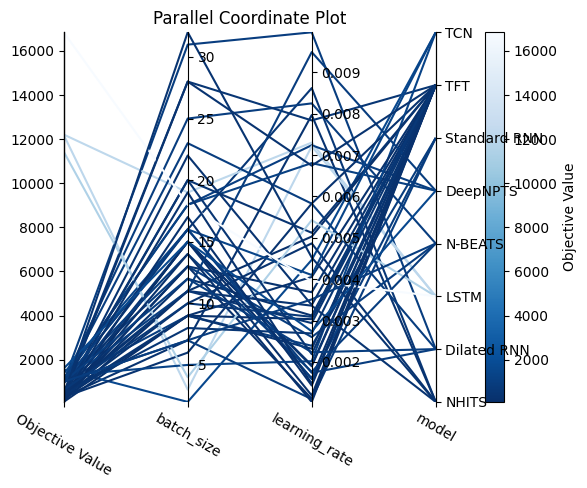

In [ ]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params = ["learning_rate", "model", "batch_size"])

# Optimized

In [ ]:
# Load the dataset
data_o = pd.read_csv("DADOS_HIDROLOGICOS_RES.csv", delimiter=';', decimal='.')
inflow_o = list(data_o['val_vazaoafluente'])
time = list(data_o['din_instante'])
inflow = inflow_o[(-365*3):-1]

# Create the time data
horizon = 14
x = inflow
time_data = pd.date_range(time[0], periods=len(x), freq='D')

# Create the DataFrame
df = pd.DataFrame({
    'unique_id': np.array(['Airline1'] * len(x)),
    'ds': time_data,
    'y': x,
    'trend': np.arange(len(x)),})

# Display the DataFrame
print(df.head())
print(df.tail())

# Split data based on your criteria
# Calculate split point for 70-10 split
split_point = int(len(df) * 0.70)

# Split data into 90% training and 10% testing
Y_train_df = df.iloc[:split_point].reset_index(drop=True)
Y_test_df = df.iloc[split_point:].reset_index(drop=True)

# Adjust input_size to fit within the training data length
input_size = min(2 * horizon, len(Y_train_df))

  unique_id         ds     y  trend
0  Airline1 2021-01-01  8708      0
1  Airline1 2021-01-02  8636      1
2  Airline1 2021-01-03  9058      2
3  Airline1 2021-01-04  9479      3
4  Airline1 2021-01-05  9941      4
     unique_id         ds     y  trend
1089  Airline1 2023-12-26  5082   1089
1090  Airline1 2023-12-27  5568   1090
1091  Airline1 2023-12-28  5450   1091
1092  Airline1 2023-12-29  5254   1092
1093  Airline1 2023-12-30  5268   1093


In [ ]:
import time
start = time.time()

models = [TFT(input_size=horizon, h=horizon, max_steps=100, learning_rate=0.00303374209742937, batch_size= 9)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.TFT[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 129    | train
-------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

6.39E+02 & 5.78E+02 & 1.06E-01 & 1.07E+01 & 256.92


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


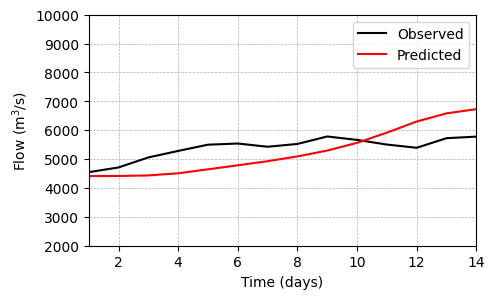

In [ ]:
fig, ((ax1)) = plt.subplots(1, figsize=(5, 3), dpi=100)

ax1.plot([0]+list(y_true),'k', zorder=2)
ax1.plot([0]+list(y_pred),'-r', zorder=2)
ax1.set_ylabel('Flow (m$^3$/s)')
ax1.set_xlabel('Time (days)')
ax1.set_xlim(1, 14)
ax1.set_ylim(2000, 10000)
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(["Observed", "Predicted"], loc="upper right", fancybox=True, shadow=False, ncol=1)
plt.show
plt.savefig('comp.pdf', bbox_inches = 'tight')

# Stats

In [ ]:
horizon = 14

In [ ]:
erro=[]
for k in range(0,50):
  x = inflow_o[(-365*3):-1]
  f = pd.Series(x, index=pd.date_range(x[0], periods=len(x), freq="D"), name="DF")
  x_resd_hp, x_trend_hp = sm.tsa.filters.hpfilter(f, 24)
  x = list(x_trend_hp)
  time_data = pd.date_range(time[0], periods=len(x), freq='D')
  df = pd.DataFrame({'unique_id': np.array(['Airline1'] * len(x)),
      'ds': time_data, 'y': x, 'trend': np.arange(len(x)),})
  split_point = int(len(df) * 0.70)
  Y_train_df = df.iloc[:split_point].reset_index(drop=True)
  Y_test_df = df.iloc[split_point:].reset_index(drop=True)
  input_size = min(2 * horizon, len(Y_train_df))

  print(k, 'iterations')
  models = [TFT(input_size=horizon, h=horizon, max_steps=100, random_seed=k, learning_rate=0.00303374209742937, batch_size= 9)]
  nf = NeuralForecast(models=models, freq='h')
  nf.fit(df=Y_train_df)
  Y_hat_df = nf.predict().reset_index()
  y_pred = Y_hat_df.TFT[:horizon]
  y_true = Y_test_df.y[:horizon]
  r = (rmse(y_true, y_pred)), (mean_absolute_error(y_true, y_pred)), (mean_absolute_percentage_error(y_true, y_pred)), (smape(y_true, y_pred))
  erro.append(r)

In [ ]:
erro = np.array(erro)
# Creating the dataframe
dfphi = pd.DataFrame({'rmse': erro[:, 0], 'mae': erro[:, 1], 'mape': erro[:, 2], 'smape': erro[:, 3]})
pd.DataFrame(erro[:, 0]).to_csv("rmse.csv", index=True)
pd.DataFrame(erro[:, 1]).to_csv("mae.csv", index=True)
pd.DataFrame(erro[:, 2]).to_csv("mape.csv", index=True)
pd.DataFrame(erro[:, 3]).to_csv("smape.csv", index=True)

In [ ]:
# calculate statistics
summary_df = pd.DataFrame({
    'Mean': dfphi.mean(),
    'Median': dfphi.median(),
    'Mode': dfphi.mode().iloc[0],
    'Range': dfphi.max() - dfphi.min(),
    'Variance': dfphi.var(),
    'Std. Dev.': dfphi.std(),
    '25th %ile': dfphi.quantile(0.25),
    '50th %ile': dfphi.quantile(0.50),
    '75th %ile': dfphi.quantile(0.75),
    'IQR': dfphi.quantile(0.75) - dfphi.quantile(0.25),
    'Skewness': dfphi.skew(),
    'Kurtosis': dfphi.kurtosis()
})

# print summary to latex
print(summary_df.transpose().round(5).to_latex())
plt.figure(figsize=(7, 3))
plt.boxplot(dfphi)
plt.legend()
plt.grid(linestyle='-', which='both')
plt.show()
plt.savefig("box.pdf", dpi=400, bbox_inches = 'tight')

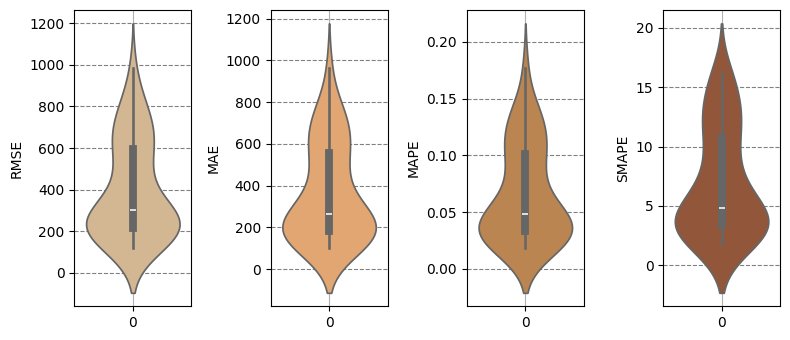

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

d1 = pd.read_csv("rmse.csv", index_col=0)
d2 = pd.read_csv("mae.csv", index_col=0)
d3 = pd.read_csv("mape.csv", index_col=0)
d4 = pd.read_csv("smape.csv", index_col=0)

# Combine the data into a single DataFrame
data = pd.concat([d1, d2, d3, d4], axis=1)
data.columns = ['RMSE', 'MAE', 'MAPE', 'SMAPE']

# Create the violin plot using seaborn
fig, axs = plt.subplots(1, 4, figsize=(8, 3.5))

sns.set_palette("flare")

# Create the violin plots and save them to the subplots
sns.violinplot(data=d1, ax=axs[0], color="burlywood")
axs[0].set_ylabel(data.columns[0])
axs[0].grid(True)
axs[0].set_axisbelow(True)
axs[0].yaxis.grid(color='gray', linestyle='dashed')

sns.violinplot(data=d2, ax=axs[1], color="sandybrown")
axs[1].set_ylabel(data.columns[1])
axs[1].grid(True)
axs[1].set_axisbelow(True)
axs[1].yaxis.grid(color='gray', linestyle='dashed')

sns.violinplot(data=d3, ax=axs[2], color="peru")
axs[2].set_ylabel(data.columns[2])
axs[2].grid(True)
axs[2].set_axisbelow(True)
axs[2].yaxis.grid(color='gray', linestyle='dashed')

sns.violinplot(data=d4, ax=axs[3], color="sienna")
axs[3].set_ylabel(data.columns[3])
axs[3].grid(True)
axs[3].set_axisbelow(True)
axs[3].yaxis.grid(color='gray', linestyle='dashed')

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig("violinplots.pdf", dpi=800, bbox_inches = 'tight')

# Benchmarking

In [ ]:
# Load the dataset
horizon = 14
data_o = pd.read_csv("DADOS_HIDROLOGICOS_RES.csv", delimiter=';', decimal='.')
inflow_o = list(data_o['val_vazaoafluente'])
time = list(data_o['din_instante'])

x = inflow_o[(-365*3):-1]
f = pd.Series(x, index=pd.date_range(x[0], periods=len(x), freq="D"), name="DF")
filter = 'True'

if filter == 'True':
  x_resd_cf, x_trend_cf = sm.tsa.filters.cffilter(f, 2, 24, False)
  x_cf = list(x_trend_cf)
  x_resd_hp, x_trend_hp = sm.tsa.filters.hpfilter(f, 24)
  x_hp = list(x_trend_hp)
  x_trend_mtsl = MSTL(f, periods=(24, 24)).fit()
  x_mstl = list(x_trend_mtsl.trend)
  stl = STL(f, trend=23, seasonal=7)
  x_stl = list((stl.fit()).trend)

  # x = x_cf
  # x = x_hp
  x = x_stl
  # x = x_mstl

  time_data = pd.date_range(time[0], periods=len(x), freq='D')
  df = pd.DataFrame({'unique_id': np.array(['Airline1'] * len(x)),
      'ds': time_data, 'y': x, 'trend': np.arange(len(x)),})
  split_point = int(len(df) * 0.70)
  Y_train_df = df.iloc[:split_point].reset_index(drop=True)
  Y_test_df = df.iloc[split_point:].reset_index(drop=True)
  input_size = min(2 * horizon, len(Y_train_df))
else:
  time_data = pd.date_range(time[0], periods=len(x), freq='D')
  df = pd.DataFrame({'unique_id': np.array(['Airline1'] * len(x)),
      'ds': time_data, 'y': x, 'trend': np.arange(len(x)),})
  split_point = int(len(df) * 0.70)
  Y_train_df = df.iloc[:split_point].reset_index(drop=True)
  Y_test_df = df.iloc[split_point:].reset_index(drop=True)
  input_size = min(2 * horizon, len(Y_train_df))

In [ ]:
import time
max_steps=100

In [ ]:
start = time.time()

models = [TFT(input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.TFT[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 129    | train
-------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

4.08E+02 & 3.95E+02 & 7.25E-02 & 7.54E+00 & 307.50


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
import time
start = time.time()

models = [DilatedRNN (input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.DilatedRNN [:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | rnn_stack       | Sequential    | 1.1 M  | train
4 | context_adapter | Linear        | 28.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.631     Total estimated model params size (MB)
19        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2.11E+04 & 2.11E+04 & 3.85E+00 & 1.31E+02 & 6.38


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
start = time.time()

models = [NHITS(input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.NHITS[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.655     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1.71E+02 & 1.44E+02 & 2.62E-02 & 2.62E+00 & 41.44


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
start = time.time()

models = [DeepNPTS(input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.DeepNPTS[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | valid_loss      | MAE           | 0      | train
2 | padder_train    | ConstantPad1d | 0      | train
3 | scaler          | TemporalNorm  | 0      | train
4 | deepnptsnetwork | Sequential    | 8.1 K  | train
----------------------------------------------------------
8.1 K     Trainable params
0         Non-trainable params
8.1 K     Total params
0.033     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


1.49E+03 & 1.40E+03 & 2.47E-01 & 2.86E+01 & 4.42


In [ ]:
start = time.time()

models = [TCN(input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.TCN[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 28.1 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
351 K     Trainable params
0         Non-trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1.81E+03 & 1.70E+03 & 3.01E-01 & 3.60E+01 & 5.56


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
start = time.time()

models = [LSTM (input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.LSTM[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 28.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.058     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1.51E+04 & 1.50E+04 & 2.75E+00 & 1.15E+02 & 5.47


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
start = time.time()

models = [RNN (input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.RNN[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 28.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
11        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

1.36E+03 & 1.27E+03 & 2.24E-01 & 2.56E+01 & 4.55


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
start = time.time()

models = [MLP (input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.MLP[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 14.3 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.317     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

5.74E+02 & 4.62E+02 & 7.92E-02 & 8.39E+00 & 20.34


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
models = [NBEATS(input_size=horizon, h=horizon, max_steps=max_steps)]
nf = NeuralForecast(models=models, freq='d')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

end = time.time()
time_s = end - start #save time

y_pred = Y_hat_df.NBEATS[:horizon]
y_true = Y_test_df.y[:horizon]

# RMSE & MAE & MAPE  & SMAPE
print(f'{(rmse(y_true, y_pred)):.2E} & {(mean_absolute_error(y_true, y_pred)):.2E} & {(mean_absolute_percentage_error(y_true, y_pred)):.2E} & {(smape(y_true, y_pred)):.2E} & {time_s:.2f}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
812       Non-trainable params
2.4 M     Total params
9.727     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

2.54E+02 & 1.57E+02 & 2.61E-02 & 2.69E+00 & 60.59


/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
